In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt, hilbert
import soundfile as sf
def low_pass_filter(signal, cutoff, fs, order=6):
    nyquist = 0.5 * fs
    normal_cutoff = cutoff / nyquist
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return filtfilt(b, a, signal)

def band_pass_filter(signal ,lowcut, highcut, fs, order=4):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='band', analog=False)
    return  filtfilt(b, a, signal)
def band_pass_filter_Custom(signal, lowcut, highcut, fs, filter_length=51):
    # Normalize the cutoff 
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist

    # shift to center
    n = np.arange(filter_length) - (filter_length - 1) / 2
    # generate sinc filter and apply smoothing
    h_low = np.sinc(2 * high * n) * np.hamming(filter_length)
    h_high = np.sinc(2 * low * n) * np.hamming(filter_length)

    # Band-pass kernel = low-pass - high-pass
    h_band = h_high - h_low
    h_band = h_band / np.sum(h_band)  # Normalize filter

    # Apply the filter to the signal
    filtered_signal = np.convolve(signal, h_band, mode='same')

    return filtered_signal

def low_pass_filter_custom(signal, cutoff, fs, filter_length=51):
    # Normalize the cutoff 
    nyquist = 0.5 * fs
    normalized_cutoff = cutoff / nyquist

    # shift to center
    n = np.arange(filter_length) - (filter_length - 1) / 2
    # generate sinc filter
    h = np.sinc(2 * normalized_cutoff * n)

    # reduce ripples by smoothing the edges
    window = np.hamming(filter_length)
    h = h * window

    # Normalize filter 
    h = h / np.sum(h)

    # Apply the filter to the signal using convolution
    filtered_signal = np.convolve(signal, h, mode='same')

    return filtered_signal, h

def ideal_lowpass_filter(signal, cutoff, fs, filter_length=101):
    
    # Frequency Domain: Create an ideal rectangular frequency response
    nyquist = fs / 2
    normalized_cutoff = cutoff / nyquist

    freq_response = np.zeros(filter_length)
    half_length = filter_length // 2

    # Set the rectangular response to 1 below the cutoff frequency
    for i in range(filter_length):
        freq = abs(i - half_length) / half_length  # Normalize frequency [-1, 1]
        if freq <= normalized_cutoff:
            freq_response[i] = 1

 


    # Convolve the input signal with the normalized impulse response
    filtered_signal = np.convolve(signal, freq_response, mode='same')

    return filtered_signal


def ideal_bandpass_filter(signal, low_cutoff, high_cutoff, fs, filter_length=101):
    
    nyquist = fs / 2
    normalized_low = low_cutoff / nyquist
    normalized_high = high_cutoff / nyquist

    # Create frequency response for a band-pass filter
    freq_response = np.zeros(filter_length)
    half_length = filter_length // 2

    for i in range(filter_length):
        freq = abs(i - half_length) / half_length  # Normalize frequency [-1, 1]
        if normalized_low <= freq <= normalized_high:
            freq_response[i] = 1

    # Inverse FFT to find impulse response
   
    filtered_signal = np.convolve(signal, freq_response, mode='same')

    return filtered_signal


def custom_modulation(message_signal, carrier_freq, fs):

    # Time vector based on sampling frequency
    t = np.arange(len(message_signal)) / fs
    
    # Carrier signal with frequency w_c
    carrier = np.cos(2 * np.pi * carrier_freq * t)
    
    # Modulated signal = m(t) * cos(w_c * t)
    modulated_signal = message_signal * carrier
    
    return modulated_signal



def plot_audio(audio, fs):
    time = np.arange(0, len(audio)/fs, 1/fs)
    plt.plot(time, audio)
    plt.xlabel("Time (s)")
    plt.ylabel("Amplitude")
    plt.title("Audio")
    plt.show()

def plot_audio_spectrum(audio, fs, show_negative=True):
    # Flatten the audio if it's 2D
    if audio.ndim > 1:
        audio = audio.flatten()
    
    N = len(audio)
    if show_negative:
        freq = np.fft.fftfreq(N, 1/fs)  # Both positive and negative frequencies
        audio_fft = np.fft.fft(audio)
    else:
        freq = np.fft.rfftfreq(N, 1/fs)  # Only positive frequencies
        audio_fft = np.fft.rfft(audio)  # real signals
    
    # Normalize magnitude 
    # regardless of the magnitude of the signal
    magnitude = np.abs(audio_fft) / N  

    plt.plot(freq, magnitude)
    plt.xlabel("Frequency (Hz)")
    plt.ylabel("Magnitude")
    plt.title("Audio Spectrum")
    plt.grid()
    plt.show()
   





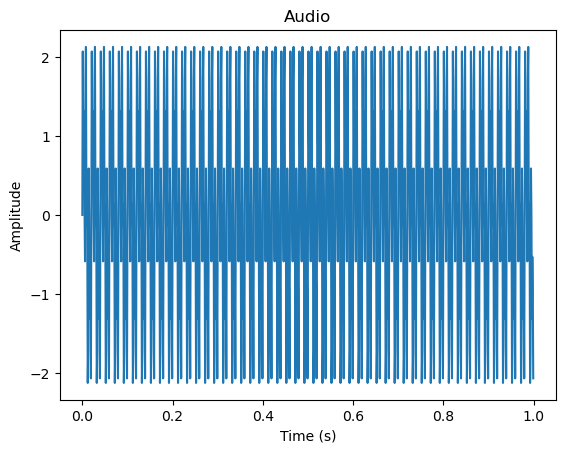

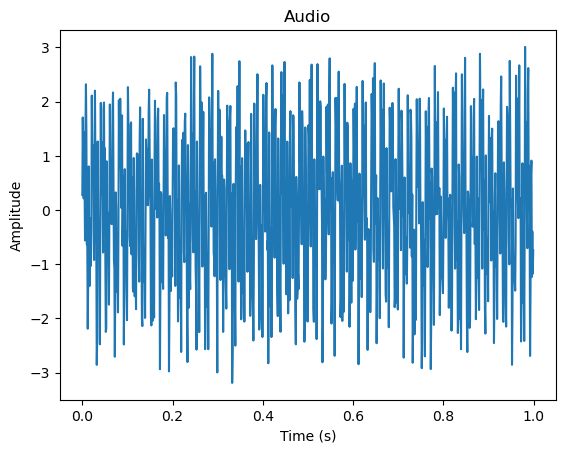

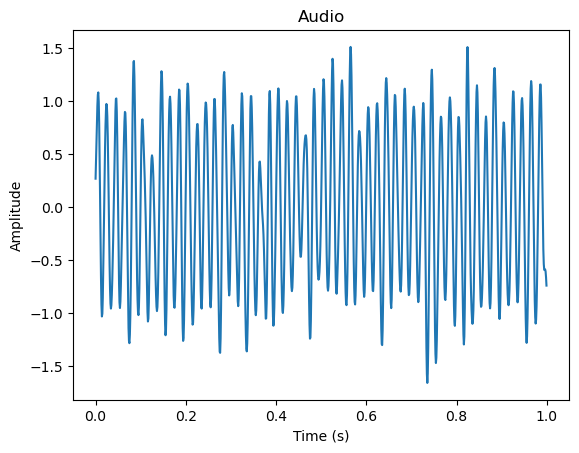

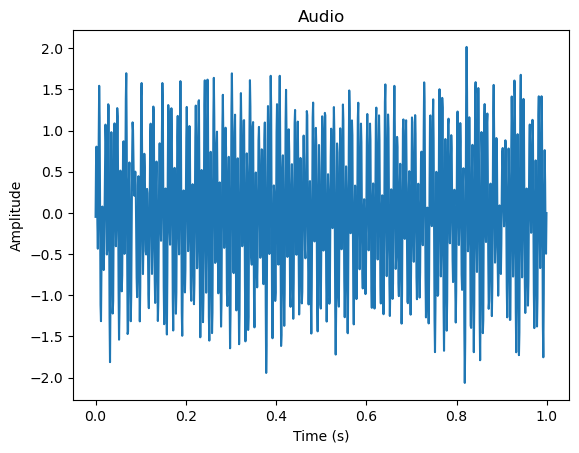

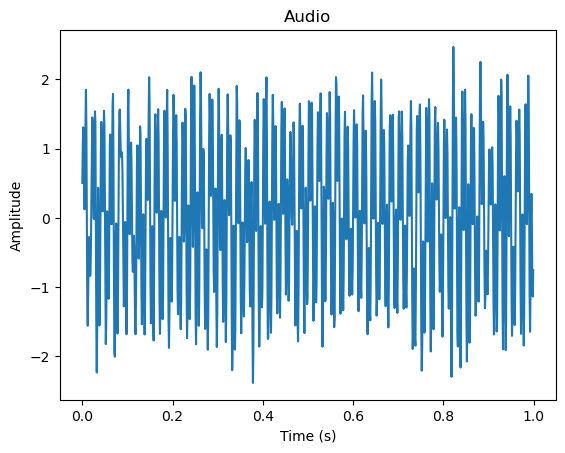

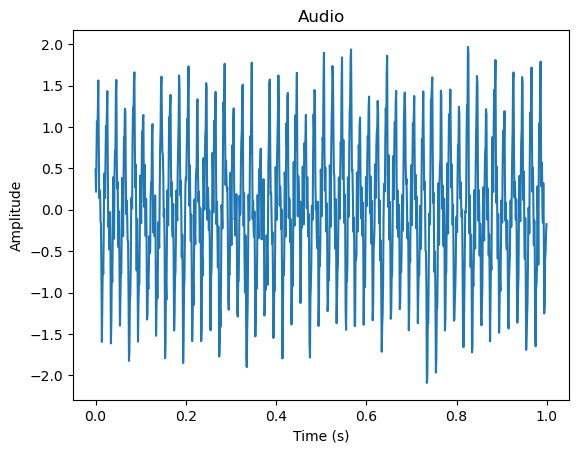

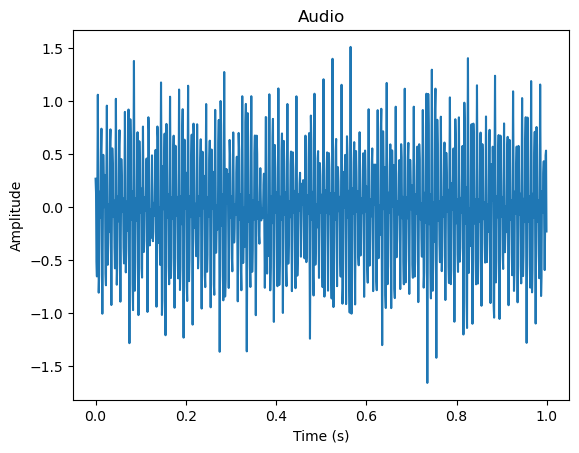

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.fftpack import fft

# Generate a sample signal: a mixture of sinusoids
fs = 1000  # Sampling frequency
t = np.linspace(0, 1, fs, endpoint=False)  # 1 second duration
freq1 = 50  # Frequency of first component
freq2 = 150  # Frequency of second component
freq3 = 300  # Frequency of third component
signal = np.sin(2 * np.pi * freq1 * t) + np.sin(2 * np.pi * freq2 * t) + np.sin(2 * np.pi * freq3 * t)

# Add noise
noise = 0.5 * np.random.normal(size=t.shape)
noisy_signal = signal + noise

# Test low-pass filter
cutoff = 100  # Cutoff frequency
filtered_signal_lp = low_pass_filter(noisy_signal, cutoff, fs)

# Test band-pass filter
lowcut = 50
highcut = 200
filtered_signal_bp = band_pass_filter(noisy_signal, lowcut, highcut, fs)

# Test custom low-pass filter
filtered_signal_lp_custom, h_lp = low_pass_filter_custom(noisy_signal, cutoff, fs)

# Test custom band-pass filter
filtered_signal_bp_custom = band_pass_filter_Custom(noisy_signal, lowcut, highcut, fs)

# Test modulation
carrier_freq = 200
modulated_signal = custom_modulation(filtered_signal_lp, carrier_freq, fs)







# Plot the original signal
plot_audio(signal, fs)


# Plot the noisy signal
plot_audio(noisy_signal, fs)


# Plot the low-pass filtered signal
plot_audio(filtered_signal_lp, fs)


# Plot the band-pass filtered signal
plot_audio(filtered_signal_bp, fs)


# Plot the custom low-pass filtered signal
plot_audio(filtered_signal_lp_custom, fs)


# Plot the custom band-pass filtered signal
plot_audio(filtered_signal_bp_custom, fs)



# Plot the modulated signal
plot_audio(modulated_signal, fs)

